# Définition des modèles 

In [ ]:
pip install tensorboardX

     |████████████████████████████████| 124 kB 5.3 MB/s 


In [ ]:
# Import 
import torch
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.nn.parameter import Parameter
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import pdb
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import sys
import tensorboardX
import os


## Datasets

In [ ]:
#Importation des données

def mnist_with_labels(class_number):
  
    raw_dataset = datasets.MNIST('../data', train=True, download=True,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                 ]))
    classes = [0] * 10
    data = []
    labels = []
    idx = 0
    perm = np.random.permutation(raw_dataset.__len__())
    for i in range(raw_dataset.__len__()):
        datum, label = raw_dataset.__getitem__(perm[i])
        if classes[label] < class_number:
            data.append(datum.numpy())
            labels.append(label)
            classes[label] += 1
            idx += 1
            if idx >= 10 * class_number:
                break
    return TensorDataset(torch.FloatTensor(np.array(data)), torch.LongTensor(np.array(labels)))

def mnist_without_labels():
    raw_dataset = datasets.MNIST('../data', train=True, download=True,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                 ]))
    return raw_dataset


def mnist_testset():
    return datasets.MNIST('../data', train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                          ]))


## Models

In [ ]:
class Discriminator(nn.Module):
    # définition des couches du Discriminateur (5 layers)
    def __init__(self, input_dim=28 ** 2, output_dim=10):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.layers = torch.nn.ModuleList([
            LinearWeightNorm(input_dim, 1000),
            LinearWeightNorm(1000, 500),
            LinearWeightNorm(500, 250),
            LinearWeightNorm(250, 250),
            LinearWeightNorm(250, 250)]
        )
        self.final = LinearWeightNorm(250, output_dim, weight_scale=1)
    # main du Discrimnateur
    def forward(self, x, feature=False, cuda=False):
        # reshape images
        x = x.view(-1, self.input_dim)
        # add gaussian noise (paper of improved GANs)
        gaussian_noise = torch.randn(x.size()) * 0.3 if self.training else torch.Tensor([0])
        # GPU
        if cuda:  
            gaussian_noise = gaussian_noise.cuda()
        x = x + Variable(gaussian_noise, requires_grad=False)
        # Pour chaque couche on calcule les paramètres puis on applique la Relu
        for i in range(len(self.layers)):
            m = self.layers[i]
            x_f = F.relu(m(x))
            gaussian_noise = torch.randn(x_f.size()) * 0.5 if self.training else torch.Tensor([0])
            if cuda:
                gaussian_noise = gaussian_noise.cuda()
            x = (x_f + Variable(gaussian_noise, requires_grad=False))
        if feature:
            return x_f, self.final(x)
        return self.final(x)


class Generator(nn.Module):
    # définition des couches du Génrateur (5 couches) 
    def __init__(self, z_dim, output_dim=28 ** 2):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.fc1 = nn.Linear(z_dim, 500, bias=False)
        self.bn1 = nn.BatchNorm1d(500, affine=False, eps=1e-6, momentum=0.5)
        self.fc2 = nn.Linear(500, 500, bias=False)
        self.bn2 = nn.BatchNorm1d(500, affine=False, eps=1e-6, momentum=0.5)
        self.fc3 = LinearWeightNorm(500, output_dim, weight_scale=1)
        self.bn1_b = Parameter(torch.zeros(500))
        self.bn2_b = Parameter(torch.zeros(500))
        # initialize the weights of a single layer
        nn.init.xavier_uniform(self.fc1.weight)
        nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, batch_size, cuda=False):
      # definir l'orde d'application des couches
        x = Variable(torch.rand(batch_size, self.z_dim), requires_grad=False, volatile=not self.training)
        if cuda:
            x = x.cuda()
        # calculer le softmax de la première couche suivi du BN (layer 1+2)
        x = F.softplus(self.bn1(self.fc1(x)) + self.bn1_b)
        # calculer le softmax de la deuxième couche suivi du BN (layer 3+4)
        x = F.softplus(self.bn2(self.fc2(x)) + self.bn2_b)
        # calcul du softmax de la 5ème couche
        x = F.softplus(self.fc3(x))
        return x


## Utils

In [ ]:
# calcul de log sum exp  (~ softmax)
def log_sum_exp(x, axis=1):
    m = torch.max(x, dim=1)[0]
    return m + torch.log(torch.sum(torch.exp(x - m.unsqueeze(1)), dim=axis))


# Redéfinition de la couche LinearWeightNorm pour modifier la sortie et ajouter des poids si nécessaire aux outputs / multiplier par des coefs
class LinearWeightNorm(torch.nn.Module):
    # Définition des couches 
    def __init__(self, in_features, out_features, bias=True, weight_scale=None, weight_init_stdv=0.1):
        super(LinearWeightNorm, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.randn(out_features, in_features) * weight_init_stdv)
        if bias:
            self.bias = Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
        if weight_scale is not None:
            assert type(weight_scale) == int
            self.weight_scale = Parameter(torch.ones(out_features, 1) * weight_scale)
        else:
            self.weight_scale = 1
     # ordre d'application des couches 
    def forward(self, x):
        W = self.weight * self.weight_scale / torch.sqrt(torch.sum(self.weight ** 2, dim=1, keepdim=True))
        return F.linear(x, W, self.bias)



## Improved GAN

In [ ]:
class ImprovedGANMNIST(object):
    ## Initialize GAN
    def __init__(self, G, D, labeled, unlabeled, test, args):
        self.writer = tensorboardX.SummaryWriter(log_dir=args.logdir)
        self.Generator = G
        self.Discriminator = D
        if args.cuda:
            self.Generator.cuda()
            self.Discriminator.cuda()
        self.labeled = labeled
        self.unlabeled = unlabeled
        self.test = test
        self.Doptim = optim.Adam(self.Discriminator.parameters(), lr=args.lr, betas=(args.momentum, 0.999))
        self.Goptim = optim.Adam(self.Generator.parameters(), lr=args.lr, betas=(args.momentum, 0.999))
        self.args = args
    
    # entrainement du discriminateur
    def train_discriminator(self, x_label, y, x_unlabel):
        x_label, x_unlabel, y = Variable(x_label), Variable(x_unlabel), Variable(y, requires_grad=False)
        if self.args.cuda:
            x_label, x_unlabel, y = x_label.cuda(), x_unlabel.cuda(), y.cuda()
        ## 
        output_label = self.Discriminator(x_label, cuda=self.args.cuda)
        output_unlabel =  self.Discriminator( x_unlabel,cuda=self.args.cuda)
        output_fake = self.Discriminator(self.Generator(x_unlabel.size()[0], cuda=self.args.cuda).view(x_unlabel.size()).detach(),
            cuda=self.args.cuda)
        logz_label, logz_unlabel, logz_fake = log_sum_exp(output_label), log_sum_exp(output_unlabel), log_sum_exp( output_fake)
        prob_label = torch.gather(output_label, 1, y.unsqueeze(1))
        loss_supervised = -torch.mean(prob_label) + torch.mean(logz_label)
        loss_unsupervised = 0.5 * (
                -torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)) +
                torch.mean(F.softplus(logz_fake)))
        loss = loss_supervised + self.args.unlabel_weight * loss_unsupervised
        # calcul de l'accuracy
        acc = torch.mean((output_label.max(1)[1] == y).float())
        # réinitialisation de l'optimiseur Adam
        self.Doptim.zero_grad()
        # calcul de la backpropagation
        loss.backward()
        # MAJ de l'optimiseur
        self.Doptim.step()
        return loss_supervised.data.cpu().numpy(), loss_unsupervised.data.cpu().numpy(), acc

    # entrainement du générateur 
    def train_generator(self, x_unlabel):
       # genrate fake images
        fake = self.Generator(x_unlabel.size()[0], cuda=self.args.cuda).view(x_unlabel.size())
        # classification of fake images with the discriminator
        mom_gen, output_fake = self.Discriminator(fake, feature=True, cuda=self.args.cuda)
        # classification of the unlabeled images with the discriminator
        mom_unlabel, _ = self.Discriminator(Variable(x_unlabel), feature=True, cuda=self.args.cuda)
        # calculate the average accuracy between fake and unlabeled images 
        mom_gen = torch.mean(mom_gen, dim=0)
        mom_unlabel = torch.mean(mom_unlabel, dim=0)
        # feature matching 
        loss_fm = torch.mean((mom_gen - mom_unlabel) ** 2)
        loss = loss_fm
        # réinitialisation de l'optimiseur 
        self.Goptim.zero_grad()
        self.Doptim.zero_grad()
        # calcul de la back propagation
        loss.backward()
        # Mise à jour de l'optimiseur
        self.Goptim.step()
        return loss.data.cpu().numpy(), fake

    def train(self):
        times = int(np.ceil(self.unlabeled.__len__() * 1. / self.labeled.__len__()))
        t1 = self.labeled.tensors[0].clone()
        t2 = self.labeled.tensors[1].clone()
        tile_labeled = TensorDataset(t1.repeat(times, 1, 1, 1), t2.repeat(times))
        gn = 0
        fake_images_list = []
        losses_supervised = []
        losses_unsupervised = []
        losses_generator = []
        acc_list = []

        for epoch in range(self.args.epochs):
            # pour chaque epoch entrainer le générateur et le discriminateur
            self.Generator.train()
            self.Discriminator.train()
            ##  iterable over a dataset
            unlabel_loader1 = DataLoader(self.unlabeled, batch_size=self.args.batch_size, shuffle=True, drop_last=True,
                                         num_workers=4)
            unlabel_loader2 = DataLoader(self.unlabeled, batch_size=self.args.batch_size, shuffle=True, drop_last=True,
                                         num_workers=4).__iter__()
            label_loader = DataLoader(tile_labeled, batch_size=self.args.batch_size, shuffle=True, drop_last=True,
                                      num_workers=4).__iter__()
            loss_supervised = loss_unsupervised = loss_gen = accuracy = 0.
            batch_num = 0
            for (unlabel1, _label1) in unlabel_loader1:
                batch_num += 1
                unlabel2, _label2 = unlabel_loader2.next()
                x, y = label_loader.next()
                if args.cuda:
                    x, y, unlabel1, unlabel2 = x.cuda(), y.cuda(), unlabel1.cuda(), unlabel2.cuda()
                ll, lu, acc = self.train_discriminator(x, y, unlabel1)
                loss_supervised += ll
                loss_unsupervised += lu
                accuracy += acc
                lg, fake_images = self.train_generator(unlabel2)
                fake_images_list.append(fake_images)
                if epoch > 1 and lg > 1:
                    lg, fake = self.train_generator(unlabel2)
                loss_gen += lg
                if (batch_num + 1) % self.args.log_interval == 0:
                    print('Training: %d / %d' % (batch_num + 1, len(unlabel_loader1)))
                    gn += 1
                    self.Discriminator.train()
                    self.Generator.train()
            loss_supervised /= batch_num
            loss_unsupervised /= batch_num
            loss_gen /= batch_num
            accuracy /= batch_num
            print("Iteration %f, loss_supervised = %.4f, loss_unsupervised = %.4f, loss_gen = %.4f train acc = %.4f" % (epoch, loss_supervised, loss_unsupervised, loss_gen, accuracy))
            sys.stdout.flush()
            accuracy_test = self.eval()/ self.test.__len__()
            if (epoch + 1) % self.args.eval_interval == 0:
                print("Eval: correct %d / %d" % (self.eval(), self.test.__len__()))
            
            #####
            losses_supervised.append(loss_supervised)
            losses_unsupervised.append(loss_unsupervised)
            losses_generator.append(loss_gen)
            acc_list.append(accuracy_test)
            #fake_images_list.append(fake_img)
            #####
        return losses_supervised, losses_unsupervised, losses_generator, acc_list, fake_images_list
   


    # évaluation des performances 
    def eval(self):
        self.Generator.eval()
        self.Discriminator.eval()
        images = [images for images, label in self.test]
        labels = [labels for images, labels in self.test]
        images, labels = torch.stack(images), torch.LongTensor(labels)
        if self.args.cuda:
            images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            pred = torch.max(self.Discriminator(Variable(images), cuda=self.args.cuda), 1)[1].data
        return torch.sum(pred == labels)


# Entrainement

## Main 

In [ ]:
class Arguments():
    batch_size=100
    epochs=10
    lr=0.003
    momentum=0.5
    cuda = True
    seed= 10
    log_interval=100
    eval_interval=1
    unlabel_weight=1
    logdir='./logs'

In [ ]:
!pip install torch-summary

In [ ]:
# visualisation des couches du discrimnateur
from torchsummary import summary

model = Discriminator()
model

Discriminator(
  (layers): ModuleList(
    (0): LinearWeightNorm()
    (1): LinearWeightNorm()
    (2): LinearWeightNorm()
    (3): LinearWeightNorm()
    (4): LinearWeightNorm()
  )
  (final): LinearWeightNorm()
)

In [ ]:
# visualisation des couches du générateur
model = Generator(100)
model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Generator(
  (fc1): Linear(in_features=100, out_features=500, bias=False)
  (bn1): BatchNorm1d(500, eps=1e-06, momentum=0.5, affine=False, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=500, bias=False)
  (bn2): BatchNorm1d(500, eps=1e-06, momentum=0.5, affine=False, track_running_stats=True)
  (fc3): LinearWeightNorm()
)

In [ ]:
args = Arguments()
args.cuda = args.cuda and torch.cuda.is_available()
np.random.seed(args.seed)
gan = ImprovedGANMNIST(Generator(100), Discriminator(), mnist_with_labels(10), mnist_without_labels(), mnist_testset(), args)
losses_sup, losses_insup, losses_gen, accuracies, fake_img = gan.train()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 0.000000, loss_supervised = 0.1724, loss_unsupervised = 0.4611, loss_gen = 0.1695 train acc = 0.9427
Eval: correct 8357 / 10000
Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 1.000000, loss_supervised = 0.0097, loss_unsupervised = 0.3797, loss_gen = 0.2604 train acc = 0.9982
Eval: correct 8845 / 10000
Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 2.000000, loss_supervised = 0.0062, loss_unsupervised = 0.3568, loss_gen = 0.3667 train acc = 0.9990
Eval: correct 8990 / 10000
Training: 100 / 600
Training: 200 / 600
Training: 300 / 600
Training: 400 / 600
Training: 500 / 600
Training: 600 / 600
Iteration 3.000000, loss_supervised = 0.0050, loss_unsupervised = 0.3620, loss_gen = 0.5244 train acc = 0.

# Résultats et interprétations 

Visualisation des images

In [ ]:
images= fake_img

In [ ]:
len(images)

6000

First image

In [ ]:
ech = images [0 :1]
len(ech)

1

In [ ]:
r = []
for e in ech:
  test1 = e.tolist()
  r.append(test1)

h = r[0][1]

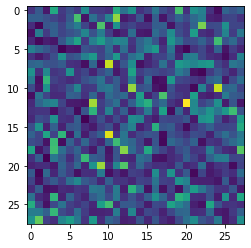

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.imsave('first.png', np.array(h).reshape(28,28), cmap=cm.gray)
plt.imshow(np.array(h).reshape(28,28))

Last image

In [ ]:
ech = images [5998 :5999]
len(ech)

1

In [ ]:
r = []
for e in ech:
  test1 = e.tolist()
  r.append(test1)

h =r[0][10]

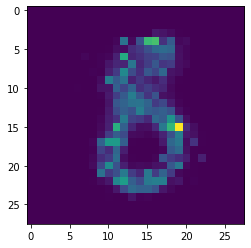

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.imsave('last.png', np.array(h).reshape(28,28), cmap=cm.gray)
plt.imshow(np.array(h).reshape(28,28))

Comme nous pouvons le constater, la première image générée est incompréhensible et ne dégage aucune information. C'est un ensemble de pixels eparpillés. La dernière image par contre représente un chiffre 8 qu'on peut lire. Cependant, la qualité de visualisation reste moyenne et ceci est du au fait qu'on a utilisé features matching. En effet, comme indiqué dans le papier l'utilisation de cette méthode donne une moins bonne qualité de visualisation comparée à la méthode minibatch discrimination.






Plot des loss et de l'accuracy

In [ ]:
# Récupération des pourcentages des accuracy pour l'ensemble test
a = accuracies
liste_acc = []
for el in a:
  y = el.tolist()
  num = round(y, 4)
  num = num*100
  num = round(num, 2)
  liste_acc.append(num)
  
liste_acc

[83.57, 88.45, 89.9, 91.15, 92.14, 93.03, 94.59, 95.32, 95.7, 96.17]

In [ ]:
# Récupération des pourcentages des loss du générateur
liste_loss_gen = []
for el in losses_gen:
  num = round(el,4)
  num = num * 100
  num = round(num,2)
  liste_loss_gen.append(num)
liste_loss_gen

[16.95, 26.04, 36.67, 52.44, 66.54, 77.98, 83.97, 88.62, 92.38, 94.25]

In [ ]:
# Récupération des pourcentages des loss du discriminateur (supervised)
liste_loss_sup = []
for el in losses_sup:
  num = round(el,4)
  num = num*100
  num = round(num,2)
  liste_loss_sup.append(num)
liste_loss_sup

[17.24, 0.97, 0.62, 0.5, 0.43, 0.34, 0.31, 0.26, 0.24, 0.24]

In [ ]:
# Récupération des pourcentages des loss du discriminateur (unsupervised)
liste_loss_unsup = []
for el in losses_insup:
  num = round(el,4)
  num = num*100
  num = round(num,2)
  liste_loss_unsup.append(num)
liste_loss_unsup

[46.11, 37.97, 35.68, 36.2, 36.66, 36.83, 37.29, 38.07, 38.28, 38.3]

No handles with labels found to put in legend.


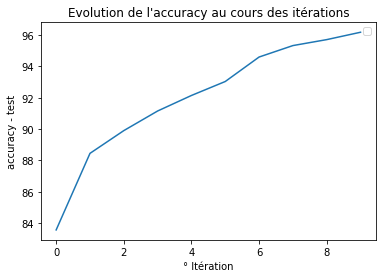

In [ ]:
import matplotlib.pyplot as plt
 
x = [0,1,2,3,4,5,6,7,8,9]
# plotting the line 1 points
plt.plot(x, liste_acc)
# naming the x axis
plt.xlabel('° Itération')
# naming the y axis
plt.ylabel('accuracy - test')
# giving a title to my graph
plt.title('Evolution de l\'accuracy au cours des itérations')
# show a legend on the plot
plt.legend()
# function to show the plot
plt.show()

Le graphe ci-dessus montre l'évolution de l'accuracy au fil des itérations. Cette dernière passe de 83% à la première epoch pour atteindre les 96% à la dernière epoch. Ceci indique que notre modèle a appris correctement à générer les images ressemblant aux images réelles de MNIST. 

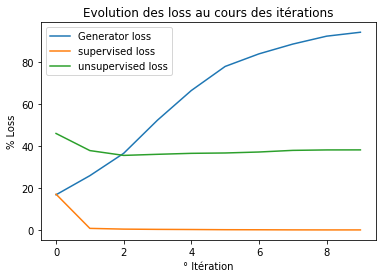

In [ ]:
import matplotlib.pyplot as plt
x = [0,1,2,3,4,5,6,7,8,9]
# line 1 points
# plotting the line 1 points
plt.plot(x, liste_loss_gen, label = "Generator loss")
 
# line 2 points
# plotting the line 2 points
plt.plot(x, liste_loss_sup, label = "supervised loss")

# line 2 points
# plotting the line 2 points
plt.plot(x, liste_loss_unsup, label = "unsupervised loss")

# naming the x axis
plt.xlabel('° Itération')
# naming the y axis
plt.ylabel('% Loss')
# giving a title to my graph
plt.title('Evolution des loss au cours des itérations')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

Les graphes ci-dessus montrent l'évolution des loss. Nous remarquons une baisse des loss supervised et unsipervised du discrimintauer ce qui est plutot positif car ceci prouve que ce dernier a appris à distinguer les fausses images des vraies. Cependant, la loss du générateur connait une évolution et ceci est logique car dans les GANs le générateur et le discriminateur sont en compétition et nous cherchons à minimiser la loss du discriminateur et à maximiser celle du générateur afin qu'il apprenne à mieux générer des images à travers ces pénalités. 